# Object detection in KITTI-MOTS

In [4]:
# Define pretrained model name
MODEL_NAME = "microsoft/conditional-detr-resnet-50"
IMAGE_SIZE = 480

## Load the dataset

### Decode and extract the whole dataset into a JSON

In [5]:
import os
import numpy as np
import json
from PIL import Image
from pycocotools import mask as maskUtils

def parse_kitti_mots_annotation(annotation_line):
    """
    Parses a single KITTI-MOTS annotation line.
    """
    fields = annotation_line.strip().split()

    frame_id = int(fields[0])  # Frame number
    object_id = int(fields[1])  # Example: 1005 (means class_id=1, instance_id=5)
    class_id = int(fields[2])  # Extract class ID
    instance_id = object_id % 1000  # Extract instance ID
    height = int(fields[3])  # Image height
    width = int(fields[4])  # Image width
    rle_str = " ".join(fields[5:])  # RLE encoding

    return {
        "frame_id": frame_id,
        "object_id": object_id,
        "class_id": class_id,
        "instance_id": instance_id,
        "height": height,
        "width": width,
        "rle_str": rle_str
    }

def decode_rle_and_get_bbox(rle_str, height, width):
    """
    Decodes RLE and computes the bounding box.
    """
    coco_rle = {
        "counts": rle_str.encode("utf-8"),
        "size": [height, width]
    }

    try:
        mask = maskUtils.decode(coco_rle)
        y_indices, x_indices = np.where(mask > 0)
        if len(y_indices) == 0 or len(x_indices) == 0:
            return mask, None, 0

        x_min, x_max = x_indices.min(), x_indices.max()
        y_min, y_max = y_indices.min(), y_indices.max()
        bbox = [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)]
        area = int(mask.sum())

        return mask, bbox, area

    except Exception as e:
        print(f"Error decoding RLE: {e}")
        return None, None, 0

def convert_kitti_mots_to_coco(annotation_folder, image_folder):
    """
    Converts KITTI-MOTS annotations to COCO format.
    """
    coco_data = []

    for txt_file in sorted(os.listdir(annotation_folder)):
        if not txt_file.endswith(".txt"):
            continue

        sequence_id = txt_file.split(".")[0]  # Example: '0000'
        txt_path = os.path.join(annotation_folder, txt_file)
        image_sequence_folder = os.path.join(image_folder, sequence_id)

        image_files = sorted(os.listdir(image_sequence_folder))
        image_data = {}

        with open(txt_path, "r") as f:
            for line in f:
                parsed = parse_kitti_mots_annotation(line)

                # Ignore annotations where class_id is 10
                if parsed["class_id"] == 10:
                    continue

                frame_id = parsed["frame_id"]

                image_filename = f"{frame_id:06d}.png"
                image_path = os.path.join(image_sequence_folder, image_filename)

                # Modify image reference to include the sequence ID (folder name)
                image_reference = os.path.join(sequence_id, image_filename)

                # Try to load image dimensions
                try:
                    with Image.open(image_path) as img:
                        width, height = img.size
                except Exception:
                    print(f"Warning: Image {image_path} not found.")
                    width, height = parsed["width"], parsed["height"]

                mask, bbox, area = decode_rle_and_get_bbox(parsed["rle_str"], parsed["height"], parsed["width"])
                if bbox is None:
                    continue

                if image_reference not in image_data:
                    image_data[image_reference] = {
                        "image_id": frame_id,  # Unique identifier
                        "image": image_reference,  # Reference includes folder
                        "width": width,
                        "height": height,
                        "objects": {"id": [], "area": [], "bbox": [], "category": []}
                    }

                image_data[image_reference]["objects"]["id"].append(parsed["instance_id"])
                image_data[image_reference]["objects"]["area"].append(area)
                image_data[image_reference]["objects"]["bbox"].append(bbox)
                image_data[image_reference]["objects"]["category"].append(parsed["class_id"])

        coco_data.extend(image_data.values())

    return coco_data

# Define paths
annotation_folder = "../data/KITTI-MOTS/instances_txt"
image_folder = "../data/KITTI-MOTS/training/images"

# Convert to COCO format
coco_annotations = convert_kitti_mots_to_coco(annotation_folder, image_folder)

# Save as JSON
with open("kitti_mots_coco.json", "w") as json_file:
    json.dump(coco_annotations, json_file, indent=4)

# Print sample output
print(json.dumps(coco_annotations[:2], indent=4))  # Print first 2 annotations

[
    {
        "image_id": 0,
        "image": "0000/000000.png",
        "width": 1242,
        "height": 375,
        "objects": {
            "id": [
                2
            ],
            "area": [
                4809
            ],
            "bbox": [
                [
                    1106.0,
                    176.0,
                    92.0,
                    142.0
                ]
            ],
            "category": [
                2
            ]
        }
    },
    {
        "image_id": 1,
        "image": "0000/000001.png",
        "width": 1242,
        "height": 375,
        "objects": {
            "id": [
                2
            ],
            "area": [
                4991
            ],
            "bbox": [
                [
                    1144.0,
                    172.0,
                    74.0,
                    141.0
                ]
            ],
            "category": [
                2
            ]
        }
    }
]


### Split Train and Test samples

In [6]:
import os
import json
import random
from datasets import Dataset, DatasetDict, Features, Value, Sequence, ClassLabel, Image

def load_kitti_mots(annotation_file):
    """Cargar anotaciones COCO en JSON"""
    with open(annotation_file, "r") as f:
        return json.load(f)

def extract_class_mapping(coco_annotations):
    """
    Extrae y remapea IDs de clase a un rango continuo,
    mapeando 1 a 'car' y 2 a 'pedestrian'.
    Solo se consideran anotaciones con clase 1 o 2.
    """
    # Definir el mapeo fijo
    fixed_mapping = {1: 0, 2: 1}
    fixed_names = {1: "car", 2: "pedestrian"}
    # Filtrar sólo anotaciones con clase 1 o 2
    class_ids = sorted(set(
        cat
        for sample in coco_annotations
        for cat in sample["objects"]["category"]
        if cat in fixed_mapping
    ))
    class_mapping = {cat: fixed_mapping[cat] for cat in class_ids}
    class_names = [fixed_names[cat] for cat in class_ids]
    return class_mapping, class_names

def split_dataset_by_sequence(coco_annotations, train_ratio=0.8, val_ratio=0.2, seed=1337):
    """
    Divide el dataset en train y validation basándose en secuencias.
    Se asume que cada muestra tiene un campo "image" con un path que incluye la carpeta de secuencia.
    """
    # Agrupar las anotaciones por secuencia (extraer la carpeta de la imagen)
    sequences = {}
    for sample in coco_annotations:
        sequence_folder = os.path.dirname(sample["image"])
        if sequence_folder not in sequences:
            sequences[sequence_folder] = []
        sequences[sequence_folder].append(sample)

    sequence_keys = list(sequences.keys())
    random.seed(seed)
    random.shuffle(sequence_keys)

    total_sequences = len(sequence_keys)
    train_count = int(total_sequences * train_ratio)

    train_keys = sequence_keys[:train_count]
    val_keys = sequence_keys[train_count:]

    # Reconstruir los splits a partir de las secuencias
    train_samples = [sample for key in train_keys for sample in sequences[key]]
    val_samples = [sample for key in val_keys for sample in sequences[key]]

    return {
        "train": train_samples,
        "validation": val_samples,
    }

def create_hf_dataset(coco_data, image_root, class_mapping, class_names):
    """
    Convierte COCO a Hugging Face Dataset sin cargar la imagen en memoria.
    Solo se incluyen objetos cuya categoría esté en el mapeo (1 o 2).
    """
    formatted_data = []
    for sample in coco_data:
        image_path = os.path.join(image_root, sample["image"])  # Guardamos la ruta de la imagen
        object_list = []
        for i in range(len(sample["objects"]["id"])):
            original_cat = sample["objects"]["category"][i]
            if original_cat not in class_mapping:
                continue
            bbox = list(map(float, sample["objects"]["bbox"][i]))
            object_list.append({
                "id": int(sample["objects"]["id"][i]),
                "area": int(sample["objects"]["area"][i]),
                "bbox": bbox,
                "category": class_mapping[original_cat]  # Re-mapeamos a índice 0 o 1
            })

        formatted_data.append({
            "image_id": int(sample["image_id"]),
            "image": image_path,
            "width": int(sample["width"]),
            "height": int(sample["height"]),
            "objects": object_list
        })

    # Definir esquema de características (sin cargar la imagen)
    features = Features({
        "image_id": Value("int64"),
        "image": Value("string"),
        "width": Value("int32"),
        "height": Value("int32"),
        "objects": Sequence({
            "id": Value("int64"),
            "area": Value("int64"),
            "bbox": Sequence(Value("float32"), length=4),
            "category": ClassLabel(names=class_names)
        })
    })

    return Dataset.from_list(formatted_data, features=features)

# Cargar dataset
annotation_file = "kitti_mots_coco.json"
image_root = "../data/KITTI-MOTS/training/images"
coco_annotations = load_kitti_mots(annotation_file)

# Extraer mapeo de clases (solo se consideran clases 1 y 2)
class_mapping, class_names = extract_class_mapping(coco_annotations)
print("Class mapping:", class_mapping)
print("Class names:", class_names)

# Dividir dataset por secuencias (80% train, 20% validation)
dataset_splits = split_dataset_by_sequence(coco_annotations)

# Convertir a Hugging Face `datasets.Dataset`
hf_dataset = DatasetDict({
    "train": create_hf_dataset(dataset_splits["train"], image_root, class_mapping, class_names),
    "validation": create_hf_dataset(dataset_splits["validation"], image_root, class_mapping, class_names),
})

# Guardar dataset
hf_dataset.save_to_disk("kitti_mots_hf")

# Imprimir estructura
print(hf_dataset["train"].features)



Class mapping: {1: 0, 2: 1}
Class names: ['car', 'pedestrian']


Saving the dataset (1/1 shards): 100%|██████████| 2163/2163 [00:00<00:00, 761864.26 examples/s]

{'image_id': Value(dtype='int64', id=None), 'image': Value(dtype='string', id=None), 'width': Value(dtype='int32', id=None), 'height': Value(dtype='int32', id=None), 'objects': Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['car', 'pedestrian'], id=None)}, length=-1, id=None)}


In [7]:
hf_dataset["train"][1]['objects']

{'id': [0],
 'area': [530],
 'bbox': [[541.0, 177.0, 29.0, 20.0]],
 'category': [0]}

### Draw an example

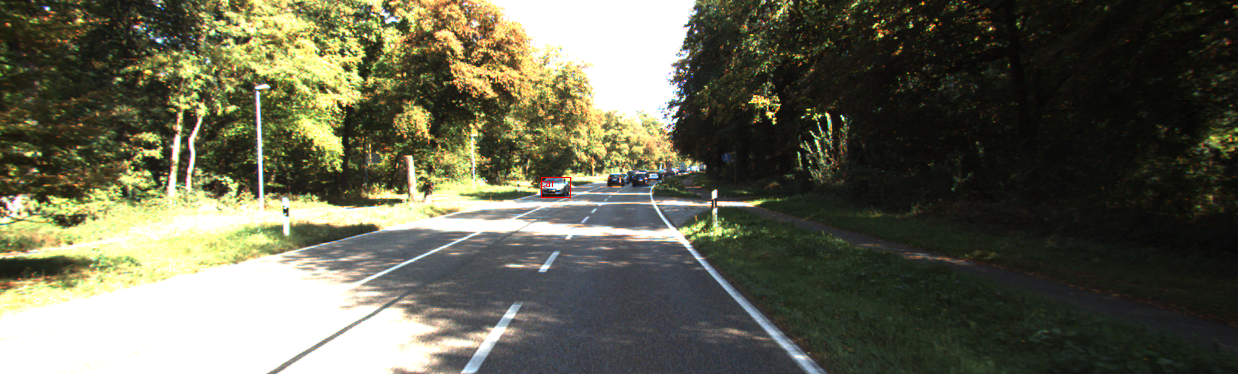

In [8]:
import numpy as np
import os
from PIL import Image, ImageDraw
import io

image = hf_dataset["train"][1]["image"]
annotations = hf_dataset["train"][1]["objects"]
image_open = Image.open(image).convert("RGB")
draw = ImageDraw.Draw(image_open)

categories = hf_dataset["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)

    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * hf_dataset["train"][1]["width"])
        y1 = int(y * hf_dataset["train"][1]["height"])
        x2 = int((x + w) * hf_dataset["train"][1]["width"])
        y2 = int((y + h) * hf_dataset["train"][1]["height"])
    draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
    draw.text((x1, y1), str(id2label[class_idx]), fill="red")

image_open

## Preprocess the data

In [9]:
from transformers import AutoImageProcessor

MAX_SIZE = IMAGE_SIZE

image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height": MAX_SIZE, "max_width": MAX_SIZE}
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [10]:
import albumentations as A

train_augment_and_transform = A.Compose(
    [
        A.NoOp()
        #A.RandomBrightnessContrast(p=0.5),
        #A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=25),
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True),
)

In [11]:
def format_image_annotations_as_coco(image_id, categories, areas, bboxes):
    """Format one set of image annotations to the COCO format

    Args:
        image_id (str): image id. e.g. "0001"
        categories (List[int]): list of categories/class labels corresponding to provided bounding boxes
        areas (List[float]): list of corresponding areas to provided bounding boxes
        bboxes (List[Tuple[float]]): list of bounding boxes provided in COCO format
            ([center_x, center_y, width, height] in absolute coordinates)

    Returns:
        dict: {
            "image_id": image id,
            "annotations": list of formatted annotations
        }
    """
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations,
    }

In [12]:
def augment_and_transform_batch(examples, transform, image_processor, return_pixel_mask=False):
    """Apply augmentations and format annotations in COCO format for object detection task"""

    images = []
    annotations = []
    for image_id, image, objects in zip(examples["image_id"], examples["image"], examples["objects"]):
        try:
            image = np.array(Image.open(image).convert("RGB"))

            # apply augmentations
            output = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
            images.append(output["image"])

            #print("Output: ", output)

            # format annotations in COCO format
            formatted_annotations = format_image_annotations_as_coco(
                image_id, output["category"], objects["area"], output["bboxes"]
            )
            annotations.append(formatted_annotations)
            #print("Formated annotations:", formatted_annotations)



        except Exception as e:
            continue

            # Apply the image processor transformations: resizing, rescaling, normalization
        result = image_processor(images=images, annotations=annotations, return_tensors="pt")

        if not return_pixel_mask:
            result.pop("pixel_mask", None)



    return result

In [13]:
from functools import partial

# Make transform functions for batch and apply for dataset splits
train_transform_batch = partial(
    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor
)
validation_transform_batch = partial(
    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor
)

hf_dataset["train"] = hf_dataset["train"].with_transform(train_transform_batch)
hf_dataset["validation"] = hf_dataset["validation"].with_transform(validation_transform_batch)


In [14]:
import torch

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data

## Preparing function to compute mAP

In [15]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]
    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.

    Args:
        boxes (torch.Tensor): Bounding boxes in YOLO format
        image_size (Tuple[int, int]): Image size in format (height, width)

    Returns:
        torch.Tensor: Bounding boxes in Pascal VOC format (x_min, y_min, x_max, y_max)
    """


    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])



    return boxes

In [16]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)

## Training the detection model

In [17]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([2]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import TrainingArguments


training_args = TrainingArguments(
    output_dir="detr_finetuned_kitti_mots-noaug-good-1",
    num_train_epochs=30,
    fp16=False,
    per_device_train_batch_size=8,
    dataloader_num_workers=4,
    learning_rate=1e-4,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    push_to_hub=True
)

In [123]:
from transformers import Trainer

# 2) Create the Trainer (the frozen parameters won't update during training)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset["train"],
    eval_dataset=hf_dataset["validation"],
    processing_class=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

# 3) Train, updating only the head
trainer.train()

Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Pedestrian,Mar 100 Pedestrian,Map Ignore,Mar 100 Ignore,Map Car,Mar 100 Car
1,1.177000,1.432156,0.136400,0.364700,0.064700,0.011400,0.133900,0.361500,0.082100,0.224700,0.321500,0.098900,0.322200,0.607000,0.060700,0.279200,-1.000000,-1.000000,0.212000,0.363800
2,1.093900,1.430258,0.157500,0.377500,0.109300,0.020700,0.146800,0.367800,0.087100,0.227700,0.319400,0.111900,0.340000,0.542600,0.068900,0.274900,-1.000000,-1.000000,0.246200,0.363900
3,1.067400,1.351398,0.181100,0.406500,0.134500,0.017000,0.187500,0.409700,0.099100,0.260300,0.351100,0.106300,0.371700,0.620000,0.075800,0.277900,-1.000000,-1.000000,0.286300,0.424400
4,0.982200,1.367470,0.170800,0.402700,0.123200,0.016600,0.182100,0.374500,0.096200,0.252300,0.346000,0.116700,0.362300,0.600500,0.077500,0.284400,-1.000000,-1.000000,0.264200,0.407700
5,0.949500,1.473850,0.164700,0.397000,0.095600,0.021700,0.159900,0.401400,0.092100,0.245700,0.327100,0.096100,0.342200,0.596600,0.076900,0.250200,-1.000000,-1.000000,0.252500,0.404100
6,0.938700,1.318228,0.194000,0.423300,0.159600,0.017100,0.213000,0.398400,0.108600,0.270400,0.365900,0.110500,0.400800,0.612400,0.090200,0.308300,-1.000000,-1.000000,0.297900,0.423500
7,0.933200,1.339929,0.202100,0.442900,0.150800,0.015400,0.205500,0.438700,0.107100,0.266700,0.350100,0.111000,0.378400,0.597800,0.107600,0.291900,-1.000000,-1.000000,0.296600,0.408300
8,0.883400,1.340343,0.210000,0.445600,0.174100,0.021600,0.218500,0.444600,0.109400,0.283600,0.374700,0.117000,0.407500,0.631100,0.110200,0.310600,-1.000000,-1.000000,0.309900,0.438800
9,0.848900,1.344362,0.208300,0.449300,0.175500,0.020800,0.218900,0.443300,0.106800,0.277400,0.369900,0.126200,0.395800,0.625600,0.102800,0.296700,-1.000000,-1.000000,0.313900,0.443200
10,0.836800,1.367458,0.207700,0.455600,0.165000,0.019500,0.214900,0.457100,0.106300,0.275200,0.365000,0.114500,0.397400,0.616700,0.112100,0.312500,-1.000000,-1.000000,0.303200,0.417500


TrainOutput(global_step=18750, training_loss=0.7158098209635416, metrics={'train_runtime': 1882.8794, 'train_samples_per_second': 79.649, 'train_steps_per_second': 9.958, 'total_flos': 8.135760086790715e+18, 'train_loss': 0.7158098209635416, 'epoch': 30.0})

In [125]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]
events.out.tfevents.1741521683.toukapy-System-Product-Name.6520.13:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

events.out.tfevents.1741519769.toukapy-System-Product-Name.6520.12:   0%|          | 0.00/51.0k [00:00<?, ?B/s]
events.out.tfevents.1741521683.toukapy-System-Product-Name.6520.13: 100%|██████████| 1.45k/1.45k [00:00<00:00, 10.5kB/s]

events.out.tfevents.1741519769.toukapy-System-Product-Name.6520.12: 100%|██████████| 51.0k/51.0k [00:00<00:00, 131kB/s]
events.out.tfevents.1741521683.toukapy-System-Product-Name.6520.13: 100%|██████████| 1.45k/1.45k [00:00<00:00, 3.61kB/s]
Upload 2 LFS files: 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


CommitInfo(commit_url='https://huggingface.co/toukapy/detr_finetuned_kitti_mots-noaug-good-1/commit/b09106a839c25e2aba84c84ab10588d0c1bb4fd5', commit_message='End of training', commit_description='', oid='b09106a839c25e2aba84c84ab10588d0c1bb4fd5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/toukapy/detr_finetuned_kitti_mots-noaug-good-1', endpoint='https://huggingface.co', repo_type='model', repo_id='toukapy/detr_finetuned_kitti_mots-noaug-good-1'), pr_revision=None, pr_num=None)

In [158]:
from pprint import pprint

metrics = trainer.evaluate(eval_dataset=hf_dataset["validation"], metric_key_prefix="val")
pprint(metrics)

{'val_loss': 47.94823455810547,
 'val_map': 0.0049,
 'val_map_50': 0.0287,
 'val_map_75': 0.0,
 'val_map_car': -1.0,
 'val_map_ignore': 0.0098,
 'val_map_large': 0.0461,
 'val_map_medium': 0.0034,
 'val_map_pedestrian': 0.0,
 'val_map_small': 0.0,
 'val_mar_1': 0.0041,
 'val_mar_10': 0.0211,
 'val_mar_100': 0.0616,
 'val_mar_100_car': -1.0,
 'val_mar_100_ignore': 0.1231,
 'val_mar_100_pedestrian': 0.0,
 'val_mar_large': 0.1281,
 'val_mar_medium': 0.0578,
 'val_mar_small': 0.0027,
 'val_model_preparation_time': 0.0022,
 'val_runtime': 23.9271,
 'val_samples_per_second': 90.399,
 'val_steps_per_second': 11.326}


## Evaluate Validation IoU

In [19]:
annotation_file = "kitti_mots_coco.json"
image_root = "../data/KITTI-MOTS/training/images"
coco_annotations = load_kitti_mots(annotation_file)

# Extraer mapeo de clases (solo se consideran clases 1 y 2)
class_mapping, class_names = extract_class_mapping(coco_annotations)
print("Class mapping:", class_mapping)
print("Class names:", class_names)

# Dividir dataset
dataset_splits = split_dataset_by_sequence(coco_annotations)

# Convertir a Hugging Face `datasets.Dataset`
hf_dataset = DatasetDict({
    "train": create_hf_dataset(dataset_splits["train"], image_root, class_mapping, class_names),
    "validation": create_hf_dataset(dataset_splits["validation"], image_root, class_mapping, class_names),
})

Class mapping: {1: 0, 2: 1}
Class names: ['car', 'pedestrian']


In [165]:
import numpy as np
from PIL import Image
import torch
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment

def center_to_corners_format(boxes):
    """
    Convert boxes from YOLO center format [x_center, y_center, width, height]
    to [xmin, ymin, xmax, ymax].
    Assumes boxes is a tensor of shape [N, 4].
    """
    x_center = boxes[:, 0]
    y_center = boxes[:, 1]
    width = boxes[:, 2]
    height = boxes[:, 3]
    xmin = x_center - width / 2
    ymin = y_center - height / 2
    xmax = x_center + width / 2
    ymax = y_center + height / 2
    return torch.stack([xmin, ymin, xmax, ymax], dim=1)

def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in [0,1]
    to Pascal VOC format (xmin, ymin, xmax, ymax) in absolute coordinates.
    """
    # Convert from center to corners.
    boxes = center_to_corners_format(boxes)
    height, width = image_size  # image_size in (height, width)
    factor = torch.tensor([width, height, width, height], dtype=boxes.dtype, device=boxes.device)
    boxes = boxes * factor
    return boxes

def compute_iou(boxA, boxB):
    """
    Compute Intersection over Union for two boxes.
    Boxes are in [xmin, ymin, xmax, ymax] format.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    interArea = inter_width * inter_height
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

# List to store mean IoU for each sample.
sample_ious = []

# Loop over the validation set.
for sample in tqdm(hf_dataset["validation"], desc="Computing IoU on validation set"):
    # 1. Get ground-truth boxes (assumed in COCO format: [xmin, ymin, width, height]) and convert.
    gt_boxes = []
    for box in sample["objects"]["bbox"]:
        xmin, ymin, w, h = box
        gt_boxes.append([xmin, ymin, xmin + w, ymin + h])
    if len(gt_boxes) == 0:
        continue  # Skip samples with no ground truth boxes.
    gt_boxes = np.array(gt_boxes)

    # 2. Run inference on the image.
    image_path = sample["image"]  # This should be the full path to the image.
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        continue
    orig_w, orig_h = image.size

    # Preprocess the image using your image_processor (which resizes/pads to 480x480).
    inputs = image_processor(images=image, return_tensors="pt")
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with torch.no_grad():
        outputs = model(**inputs)
    # Use post_process_object_detection to rescale predictions to original image size.
    target_sizes = torch.tensor([[orig_h, orig_w]]).to(device)
    results = image_processor.post_process_object_detection(
        outputs, threshold=0.2, target_sizes=target_sizes
    )[0]

    pred_boxes = []
    # Collect predicted boxes in [xmin, ymin, xmax, ymax] format.
    for box in results["boxes"]:
        # If your predictions were in YOLO format, you could convert them:
        # boxes_tensor = torch.tensor(box).unsqueeze(0)  # shape [1,4]
        # box_converted = convert_bbox_yolo_to_pascal(boxes_tensor, (orig_h, orig_w))
        # pred_boxes.append(box_converted.squeeze(0).tolist())
        # Otherwise, if they are already in [xmin, ymin, xmax, ymax]:
        pred_boxes.append(box.tolist())
    if len(pred_boxes) == 0:
        continue  # Skip sample if no predictions.
    pred_boxes = np.array(pred_boxes)

    # 3. Compute IoU matrix between ground truth and predicted boxes.
    iou_matrix = np.zeros((len(gt_boxes), len(pred_boxes)))
    for i, gt in enumerate(gt_boxes):
        for j, pred in enumerate(pred_boxes):
            iou_matrix[i, j] = compute_iou(gt, pred)

    # 4. Use Hungarian matching to maximize total IoU.
    # Since linear_sum_assignment minimizes cost, we pass -IoU as the cost.
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    matched_ious = iou_matrix[row_ind, col_ind]

    # Average IoU for this sample.
    sample_mean_iou = np.mean(matched_ious)
    sample_ious.append(sample_mean_iou)

# Compute overall mean IoU across samples.
if sample_ious:
    mean_iou = np.mean(sample_ious)
    print("Mean IoU over validation set:", mean_iou)
else:
    print("No samples with both ground truth and predictions to evaluate.")



Computing IoU on validation set: 100%|██████████| 2163/2163 [02:19<00:00, 15.49it/s]

Mean IoU over validation set: 0.42876445155966536


## Evaluate in Test images

In [168]:
import os
import torch
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoModelForObjectDetection
from tqdm import tqdm

# Initialize the feature extractor and DETR model
# (Assumes that 'image_processor', 'id2label', and 'label2id' are defined)
feature_extractor = image_processor
model = AutoModelForObjectDetection.from_pretrained(
    "toukapy/detr_finetuned_kitti_mots-withaug-3-laura",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

# Define base paths for input images and for output images (with drawn detections)
input_base = "../data/KITTI-MOTS/testing/images"
output_base = "../data/KITTI-MOTS/testing/detecciones"

# Load a default font for drawing text
font = ImageFont.load_default()

# Recorre la estructura de directorios en input_base
for root, dirs, files in os.walk(input_base):
    for file in tqdm(files):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            # Build full path for current image
            input_path = os.path.join(root, file)
            # Preserve relative directory structure
            rel_dir = os.path.relpath(root, input_base)
            out_dir = os.path.join(output_base, rel_dir)
            os.makedirs(out_dir, exist_ok=True)
            out_file = os.path.join(out_dir, file)

            # Open the original image (for final drawing) and get its size
            image = Image.open(input_path).convert("RGB")
            orig_width, orig_height = image.size

            # Resize image to (480, 480) for inference, as in training

            # Preprocess the resized image and run inference
            inputs = feature_extractor(images=image, return_tensors="pt")
            outputs = model(**inputs)
            # Set target_sizes to the original image size so boxes are scaled correctly
            target_sizes = torch.tensor([[orig_height, orig_width]])
            results = feature_extractor.post_process_object_detection(
                outputs, threshold=0.3, target_sizes=target_sizes
            )[0]

            # Prepare to draw on the original image
            draw = ImageDraw.Draw(image)

            # Loop through detections and draw boxes and labels
            for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
                # The output box is now [xmin, ymin, xmax, ymax] in original image coordinates
                box = box.tolist()
                xmin, ymin, xmax, ymax = map(int, box)
                class_name = model.config.id2label[label.item()]
                score_val = round(score.item(), 3)
                text = f"{class_name}: {score_val}"

                # Draw bounding box (red rectangle)
                draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=2)

                # Compute text bounding box using draw.textbbox
                text_bbox = draw.textbbox((xmin, ymin), text, font=font)
                text_width = text_bbox[2] - text_bbox[0]
                text_height = text_bbox[3] - text_bbox[1]

                # Draw a filled rectangle behind the text for better visibility
                draw.rectangle((xmin, ymin, xmin + text_width, ymin + text_height), fill="red")
                # Draw the text in white
                draw.text((xmin, ymin), text, fill="white", font=font)

            # Save the resulting image with drawn detections
            image.save(out_file)

0it [00:00, ?it/s]
 21%|██        | 163/774 [00:23<01:28,  6.91it/s]


KeyboardInterrupt: 

## Evaluate in Validation images

In [169]:
import os
import ast
import torch
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoModelForObjectDetection
from tqdm import tqdm

input_base = "../data/KITTI-MOTS/training/images"
output_base = "../data/KITTI-MOTS/detect_val_bright_good"
os.makedirs(output_base, exist_ok=True)

feature_extractor = image_processor
model = AutoModelForObjectDetection.from_pretrained(
    "toukapy/detr_finetuned_kitti_mots-horizon-good-1",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

font = ImageFont.load_default()

def load_ground_truth_by_index(idx):
    gt_objects = hf_dataset["validation"]["objects"][idx]
    if isinstance(gt_objects, str):
        gt_objects = ast.literal_eval(gt_objects)

    gt_list = []
    for i in range(len(gt_objects['id'])):
        x, y, w, h = gt_objects['bbox'][i]
        xmin, ymin, xmax, ymax = x, y, x + w, y + h
        label = gt_objects['category'][i]
        gt_list.append({"bbox": [xmin, ymin, xmax, ymax], "label": label})
    return gt_list

num_images = len(hf_dataset["validation"]["image"])
for i in range(num_images):
    file_name = hf_dataset["validation"]["image"][i]
    input_path = os.path.join(input_base, file_name)
    out_path = output_base + "/" + file_name.split("/")[-2] + "/" + file_name.split("/")[-1]

    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    try:
        image = Image.open(input_path).convert("RGB")
    except Exception as e:
        print("Error al abrir la imagen", input_path, e)
        continue

    orig_width, orig_height = image.size

    # Image processing and detection
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([[orig_height, orig_width]])
    results = feature_extractor.post_process_object_detection(
        outputs, threshold=0.3, target_sizes=target_sizes
    )[0]

    # Draw predictions in red
    draw = ImageDraw.Draw(image)
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = box.tolist()
        xmin, ymin, xmax, ymax = map(int, box)
        class_name = model.config.id2label[label.item()]
        score_val = round(score.item(), 3)
        text = f"{class_name}: {score_val}"
        draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=2)
        text_bbox = draw.textbbox((xmin, ymin), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        draw.rectangle((xmin, ymin, xmin + text_width, ymin + text_height), fill="red")
        draw.text((xmin, ymin), text, fill="white", font=font)

    # Draw ground truth annotations in green
    try:
        gt_annotations = load_ground_truth_by_index(i)
        for gt in gt_annotations:
            xmin, ymin, xmax, ymax = map(int, gt["bbox"])
            text = f"GT: {gt['label']}"
            draw.rectangle((xmin, ymin, xmax, ymax), outline="green", width=2)
            text_bbox = draw.textbbox((xmin, ymin), text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            draw.rectangle((xmin, ymin, xmin + text_width, ymin + text_height), fill="green")
            draw.text((xmin, ymin), text, fill="white", font=font)
    except Exception as e:
        print("Error al procesar ground truth para", file_name, e)

    try:
        image.save(out_path)
        print("Imagen guardada en:", out_path)
    except Exception as e:
        print("Error al guardar la imagen", out_path, e)


Imagen guardada en: /home/toukapy/Documentos/Master CV/C5/mcv-c5-team2/week1/data/KITTI-MOTS/detect_val_bright_good/0010/000000.png
Imagen guardada en: /home/toukapy/Documentos/Master CV/C5/mcv-c5-team2/week1/data/KITTI-MOTS/detect_val_bright_good/0010/000001.png
Imagen guardada en: /home/toukapy/Documentos/Master CV/C5/mcv-c5-team2/week1/data/KITTI-MOTS/detect_val_bright_good/0010/000002.png
Imagen guardada en: /home/toukapy/Documentos/Master CV/C5/mcv-c5-team2/week1/data/KITTI-MOTS/detect_val_bright_good/0010/000003.png
Imagen guardada en: /home/toukapy/Documentos/Master CV/C5/mcv-c5-team2/week1/data/KITTI-MOTS/detect_val_bright_good/0010/000004.png
Imagen guardada en: /home/toukapy/Documentos/Master CV/C5/mcv-c5-team2/week1/data/KITTI-MOTS/detect_val_bright_good/0010/000005.png
Imagen guardada en: /home/toukapy/Documentos/Master CV/C5/mcv-c5-team2/week1/data/KITTI-MOTS/detect_val_bright_good/0010/000006.png
Imagen guardada en: /home/toukapy/Documentos/Master CV/C5/mcv-c5-team2/week1

## Infer and Evaluate DETR without finetuning

In [ ]:
import torch
from transformers import AutoFeatureExtractor, ConditionalDetrForObjectDetection
from PIL import Image
import os

# Para la evaluación con pycocotools
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import copy

# ------------------------------
# Cargar modelo y feature extractor
model_name = "microsoft/conditional-detr-resnet-50"
model = ConditionalDetrForObjectDetection.from_pretrained(model_name)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model.eval()

# ------------------------------
# Función para obtener predicciones para una imagen individual
def get_predictions(sample, threshold=0.2):
    image = Image.open(sample["image"]).convert("RGB")

    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    # target_sizes espera (height, width)
    target_sizes = torch.tensor([image.size[::-1]])
    results = feature_extractor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=threshold
    )[0]

    predictions = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        x_min, y_min, x_max, y_max = box.tolist()
        width = x_max - x_min
        height = y_max - y_min
        predictions.append({
            "image_id": sample["image_id"],
            "category_id": int(label),  # Debe coincidir con el ID de la categoría
            "bbox": [x_min, y_min, width, height],
            "score": float(score)
        })
    return predictions

# ------------------------------
# Ejemplo de dataset con las claves necesarias:
# hf_dataset["validation"] -> lista/diccionario con:
# {
#   "image_id": ...,
#   "image": "ruta_a_la_imagen.jpg",
#   "width": ...,
#   "height": ...,
#   "objects": {
#       "id": [...],
#       "category": [...],
#       "bbox": [...],  # en formato [x, y, width, height]
#       "area": [...]
#   }
# }

all_predictions = []
images = []
annotations = []
annotation_id = 1

# Define las categorías (IDs consistentes con tus predicciones)
categories = [
    {"id": 0, "name": "car"},
    {"id": 1, "name": "person"}
]

# Recorremos el conjunto de validación para construir anotaciones y predicciones
for sample in hf_dataset["validation"]:
    images.append({
        "id": sample["image_id"],
        "width": sample["width"],
        "height": sample["height"]
    })

    # Agregar anotaciones ground truth
    for i in range(len(sample["objects"]["id"])):
        annotations.append({
            "id": annotation_id,
            "image_id": sample["image_id"],
            "category_id": sample["objects"]["category"][i],
            "bbox": sample["objects"]["bbox"][i],
            "area": sample["objects"]["area"][i],
            "iscrowd": 0
        })
        annotation_id += 1

    # Obtener predicciones
    preds = get_predictions(sample, threshold=0.1)
    all_predictions.extend(preds)

# ------------------------------
# Construir el diccionario de ground truth en formato COCO
gt_dict = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}

# Crear el objeto COCO de ground truth
coco_gt = COCO()
coco_gt.dataset = gt_dict
coco_gt.createIndex()

# Cargar las detecciones en formato COCO
coco_dt = coco_gt.loadRes(all_predictions)

# ------------------------------
# Función para obtener métricas mAP@0.5:0.95 y mAP@0.5
def evaluate_coco(coco_gt, coco_dt, catIds=None):
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    # Filtra por categorías si se especifican (car -> [0], person -> [1])
    if catIds is not None:
        coco_eval.params.catIds = catIds

    # Realiza la evaluación con el rango por defecto de IoU (0.5 a 0.95)
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # coco_eval.stats es un array con 12 índices:
    # stats[0] = AP (IoU=0.5:0.95) - área: all
    # stats[1] = AP (IoU=0.5)      - área: all
    # stats[2] = AP (IoU=0.75)     - área: all
    # ...
    mAP_50_95 = coco_eval.stats[0]  # AP promedio en IoU de 0.5 a 0.95
    mAP_50 = coco_eval.stats[1]     # AP a IoU=0.5
    return mAP_50_95, mAP_50

# ------------------------------
# 1) Métricas para todas las categorías juntas
mAP_50_95_all, mAP_50_all = evaluate_coco(coco_gt, coco_dt, catIds=None)
print(f"mAP@0.5:0.95 (All): {mAP_50_95_all:.3f}")
print(f"mAP@0.5 (All): {mAP_50_all:.3f}")

# 2) Métricas para 'car' (ID=0)
mAP_50_95_car, mAP_50_car = evaluate_coco(coco_gt, coco_dt, catIds=[0])
print(f"mAP@0.5:0.95 (Car): {mAP_50_95_car:.3f}")
print(f"mAP@0.5 (Car): {mAP_50_car:.3f}")

# 3) Métricas para 'person' (ID=1)
mAP_50_95_person, mAP_50_person = evaluate_coco(coco_gt, coco_dt, catIds=[1])
print(f"mAP@0.5:0.95 (Person): {mAP_50_95_person:.3f}")
print(f"mAP@0.5 (Person): {mAP_50_person:.3f}")





/home/toukapy/PycharmProjects/gazecaps/my_env/lib/python3.12/site-packages/transformers/models/conditional_detr/feature_extraction_conditional_detr.py:38: FutureWarning: The class ConditionalDetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConditionalDetrImageProcessor instead.
  warnings.warn(
